# Protein-Protein Interaction Network Analysis in *P.vulgatus*

## API-Based Data Access

This notebook has been updated to use the METT Data Portal API instead of local CSV files. The API provides:

- **Real-time data access**: Always up-to-date PPI interaction data
- **Flexible filtering**: Filter by species, score types, evidence types, and confidence levels
- **Network analysis**: Built-in network properties and neighborhood analysis
- **Scalable**: Handles large datasets efficiently through pagination

### API Endpoints Used:
- `/api/ppi/interactions` - Search PPI interactions with filtering
- `/api/ppi/network-properties` - Get network statistics
- `/api/ppi/neighborhood/{protein_id}` - Get protein neighborhood data

### Configuration:
- **API Base URL**: `http://localhost:8000/api` (update as needed)
- **Species**: Phocaeicola vulgatus (PV) by default
- **Data Source**: Elasticsearch PPI index


## 1. Data Loading and Network Construction

First, we'll load the required libraries and import the protein interaction data along with gene annotations.

### Protein-Protein Interaction Predictors

This analysis utilizes multiple experimental and computational methods to predict protein-protein interactions (PPIs) in *P. vulgatus*. Each predictor provides unique insights into potential protein associations:

**Experimental Methods:**
- **gp_score**: Correlation across growth phases measured using expression proteomics - identifies proteins that co-vary in abundance during different bacterial growth conditions
- **perturb_score**: Correlation across >50 perturbations measured using expression proteomics - captures protein co-regulation under diverse environmental stresses
- **melt_score**: Co-melting from thermal proteome profiling measured at 10 temperatures in basal state - detects proteins that physically associate and have similar thermal stability
- **sec_score**: Interactions observed from co-occurrence in size exclusion chromatography experiments - identifies protein complexes based on similar elution profiles
- **bn_score**: Interactions observed from co-occurrence in blue native PAGE experiments - detects native protein complexes under non-denaturing conditions
- **xlms_peptides**: Number of unique cross-linked peptide pairs observed in XL-MS experiments - provides direct evidence of protein proximity and binding sites

**Computational Methods:**
- **ds_score**: Predictions from sequence alone using a deep learning model - leverages evolutionary patterns and sequence features to predict interactions
- **string_physical_score**: Physical interactions from STRING database - incorporates known interactions from literature and databases
- **operon_score**: Predictions based on operon organization - utilizes the tendency of functionally related genes to be co-located in bacterial genomes

Each predictor contributes different types of evidence for protein interactions, and combining multiple predictors provides a more comprehensive view of the protein interaction landscape.

In [1]:
from utils_api import *
import matplotlib.pyplot as plt

In [2]:
# Load data from API instead of CSV files
species_acronym = 'PV'  # Phocaeicola vulgatus

gff_df = load_gff_annotation(species_acronym)
interactions_df = load_interactions(species_acronym)

Available columns in interactions_df: ['protein_a', 'protein_b', 'ds_score', 'tt_score', 'perturb_score', 'gp_score', 'melt_score', 'sec_score', 'bn_score', 'string_physical_score', 'operon_score', 'ecocyc_score', 'xlms_peptides', 'protein_a_locus_tag', 'protein_a_uniprot_id', 'protein_a_name', 'protein_a_product', 'protein_b_locus_tag', 'protein_b_uniprot_id', 'protein_b_name', 'protein_b_product']
Shape of interactions_df: (10000, 21)
genes_a columns before rename: ['protein_a', 'protein_a_locus_tag', 'protein_a_uniprot_id', 'protein_a_name', 'protein_a_product']
genes_a shape: (10000, 5)
genes_b columns before rename: ['protein_b', 'protein_b_locus_tag', 'protein_b_uniprot_id', 'protein_b_name', 'protein_b_product']
genes_b shape: (10000, 5)
all_genes columns: ['uniprot_id', 'locus_tag', 'uniprot_id_alt', 'name', 'product']
all_genes shape: (3586, 5)
uniprot_id column type: <class 'pandas.core.series.Series'>
uniprot_id shape: (3586,)


# 2. Network Properties Exploration

## Understanding Network Construction and Metrics

The `interaction_network_from_df()` function is the core tool for building protein interaction networks from our data. Here's how it works:

**Function Parameters:**
- `interactions_df`: The input DataFrame containing protein pairs and their interaction scores
- `score_col`: The column name containing the interaction confidence scores (e.g., 'gp_score', 'melt_score')
- `score_threshold`: The minimum score required to include an interaction in the network (higher values = more stringent filtering)

**Network Construction Process:**
1. Filters the interaction DataFrame to retain only pairs with scores ≥ the specified threshold
2. Creates edges between protein pairs (nodes) weighted by their interaction scores
3. Returns a NetworkX graph object for further analysis

**Key Network Metrics Displayed:**

- **Number of nodes**: Total unique proteins in the network
- **Number of edges**: Total protein-protein interactions above the threshold
- **Density**: Fraction of possible edges that actually exist (ranges 0-1, where 1 = fully connected)
- **Average clustering coefficient**: Measures how interconnected a protein's neighbors are (higher values indicate more modular, clustered network structure)
- **Degree distribution**: Shows how many connections each protein has - helps identify highly connected "hub" proteins

These metrics help assess network quality and identify biologically relevant features like protein complexes and functional modules.

Number of nodes: 1139
Number of edges: 5449
Density: 0.0084
Average clustering coefficient: 0.3861


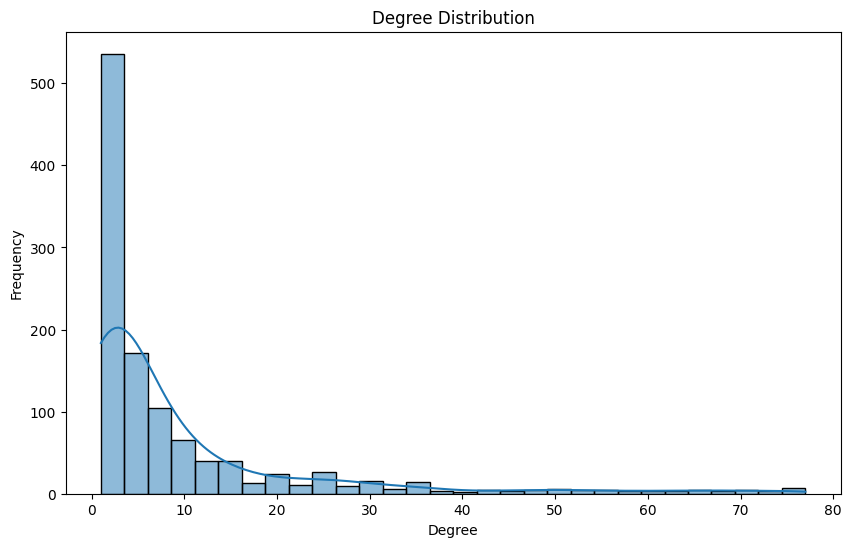

In [3]:
# example for growth_phase network using API
plot_network_properties_from_api('abundance_score', 0.95, species_acronym)

Number of nodes: 2716
Number of edges: 47970
Density: 0.0130
Average clustering coefficient: 0.3664


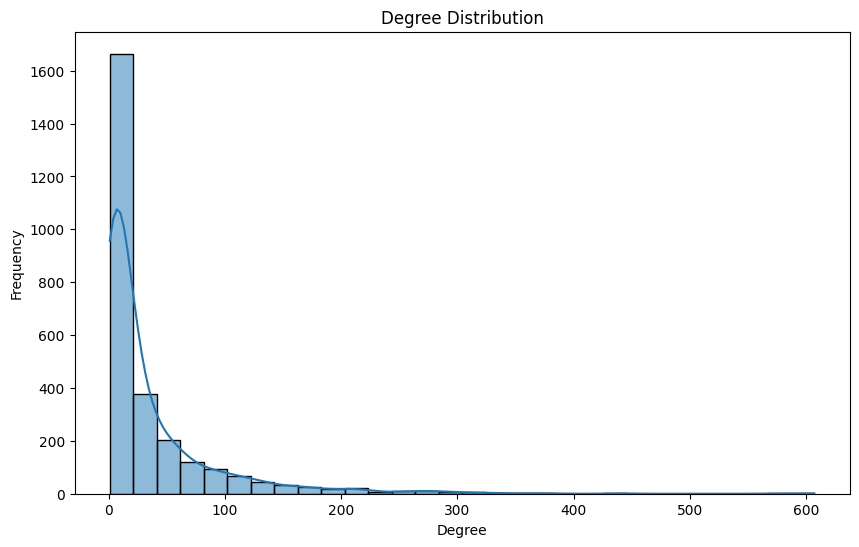

In [4]:
# example for crosslinking network using API
# Note: XL-MS data is filtered by has_xlms flag in the API
plot_network_properties_from_api('ds_score', 0.8, species_acronym)

## 3. Visualizing Neighborhoods of Key Proteins

### Biological Significance of Protein Neighborhood Analysis

Exploring the neighborhood of a protein of interest is a powerful approach for functional annotation and hypothesis generation. This analysis leverages the principle of "guilt by association" - proteins that interact with each other often share similar functions or participate in related biological processes.

**Key Benefits of Neighborhood Exploration:**

1. **Functional Annotation**: Unknown or poorly characterized proteins can be assigned putative functions based on their well-characterized interaction partners

2. **Pathway Discovery**: Identifying clusters of interacting proteins can reveal previously unknown biological pathways or protein complexes

3. **Drug Target Identification**: Understanding a protein's interaction network helps predict potential side effects and identify alternative therapeutic targets

4. **Systems-Level Understanding**: Rather than studying proteins in isolation, neighborhood analysis provides insights into how proteins function as part of larger biological systems

**Interpretation Strategy:**
- **Close neighbors** (distance 1): Direct interaction partners, often share immediate functional relationships
- **Extended neighborhood**: Proteins within 2-3 interaction steps may participate in the same pathway or process
- **Network topology**: Dense, highly connected neighborhoods often represent stable protein complexes or functional modules

The visualization below shows a randomly selected protein and its closest interacting partners, annotated with gene IDs and functional descriptions to facilitate biological interpretation.

Proteins known to have neighbor-to-neighbor interactions:
1. A6L7C0
2. A6L0B3
3. A6KYE9
4. A6KZZ3
5. A6KXW7

Trying protein: A6L7C0
Calling API for protein: A6L7C0
Retrieved neighborhood data for protein: A6L7C0
Number of neighbors: 5
Network data - nodes: 6, edges: 8
Created graph with 6 nodes and 8 edges
Available columns in interactions_df: ['protein_a', 'protein_b', 'ds_score', 'tt_score', 'perturb_score', 'gp_score', 'melt_score', 'sec_score', 'bn_score', 'string_physical_score', 'operon_score', 'ecocyc_score', 'xlms_peptides', 'protein_a_locus_tag', 'protein_a_uniprot_id', 'protein_a_name', 'protein_a_product', 'protein_b_locus_tag', 'protein_b_uniprot_id', 'protein_b_name', 'protein_b_product']
Shape of interactions_df: (10000, 21)
genes_a columns before rename: ['protein_a', 'protein_a_locus_tag', 'protein_a_uniprot_id', 'protein_a_name', 'protein_a_product']
genes_a shape: (10000, 5)
genes_b columns before rename: ['protein_b', 'protein_b_locus_tag', 'protein_b_uniprot_id', 'p

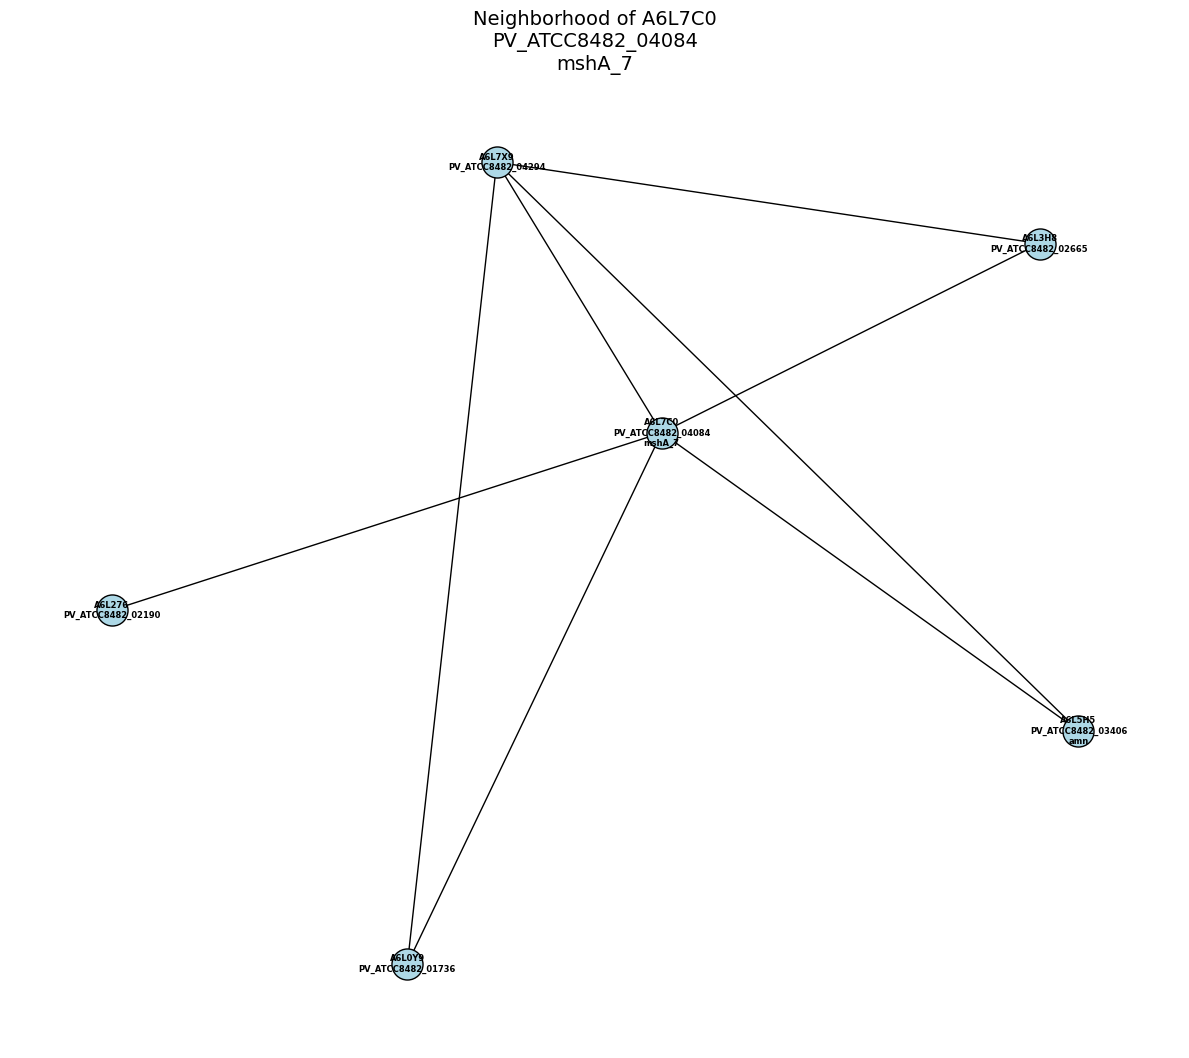

Successfully plotted neighborhood for A6L7C0


In [10]:
# Reload the utils_api module to get the latest changes
import importlib
import utils_api
importlib.reload(utils_api)
from utils_api import plot_neighborhood_from_api

# Use a protein that we know has neighbor-to-neighbor interactions
# Based on our testing, A6L7C0, A6L0B3, and A6KYE9 have neighbor-to-neighbor interactions
proteins_with_neighbor_interactions = ["A6L7C0", "A6L0B3", "A6KYE9", "A6KZZ3", "A6KXW7"]

print("Proteins known to have neighbor-to-neighbor interactions:")
for i, protein in enumerate(proteins_with_neighbor_interactions, 1):
    print(f"{i}. {protein}")

# Try the first one that works
for protein_id in proteins_with_neighbor_interactions:
    print(f"\nTrying protein: {protein_id}")
    try:
        plot_neighborhood_from_api(protein_id, n=5, species_acronym=species_acronym)
        print(f"Successfully plotted neighborhood for {protein_id}")
        break
    except Exception as e:
        print(f"Error with {protein_id}: {e}")
        continue
else:
    print("None of the known proteins worked. Trying random selection...")
    
    # Fallback to random selection
    np.random.seed(555)
    for attempt in range(5):
        random_protein = np.random.choice(interactions_df['protein_a'].unique())
        print(f"Trying random protein {attempt + 1}: {random_protein}")
        
        try:
            plot_neighborhood_from_api(random_protein, n=5, species_acronym=species_acronym)
            print(f"Successfully plotted neighborhood for {random_protein}")
            break
        except Exception as e:
            print(f"Error with {random_protein}: {e}")
            continue
    else:
        print("Could not find a protein with a plottable neighborhood.")

## 4. Unsupervised exploration of highly connected proteins

### Biological Significance of Highly Connected Proteins

Highly connected proteins, often called "hubs," play crucial roles in cellular networks and are prime candidates for further biological investigation. These proteins tend to be:

**Functionally Important:**
- **Essential proteins**: Hub proteins are more likely to be essential for cell viability
- **Regulatory proteins**: Often involved in coordinating multiple cellular processes
- **Metabolic enzymes**: Central enzymes in metabolic pathways frequently have many interaction partners
- **Structural proteins**: Components of large protein complexes or scaffolding proteins

**Therapeutically Relevant:**
- **Drug targets**: Disrupting hub proteins can have broad effects, making them attractive therapeutic targets
- **Disease association**: Mutations in hub proteins are more likely to cause disease phenotypes
- **Biomarkers**: Changes in hub protein expression/activity may serve as indicators of cellular state

### Clustering Coefficient as a Discovery Tool

The clustering coefficient measures how interconnected a protein's neighbors are to each other. Proteins with high clustering coefficients are particularly interesting because:

1. **Complex Membership**: High clustering often indicates participation in stable protein complexes where all members interact with each other

2. **Functional Modules**: Proteins in the same functional pathway or biological process tend to form highly clustered neighborhoods

3. **Structural Organization**: High clustering can indicate proteins that serve as scaffolds or organizing centers for larger assemblies

**Why Prioritize High Clustering Coefficient Proteins:**
- They likely represent core components of important cellular machinery
- Their neighborhoods are more likely to be functionally coherent
- They offer well-defined starting points for characterizing entire functional modules
- Disrupting these proteins may have predictable, module-specific effects

The analysis below identifies the protein with the highest clustering coefficient and visualizes its neighborhood to reveal potential functional associations.

Analyzing network properties for melt_score (threshold: 0.98)...
Network has 1993 nodes and 37994 edges
Average clustering coefficient: 0.4784

Building local network for clustering coefficient analysis...
Protein with highest clustering coefficient: A6KYE9
Plotting neighborhood for A6KYE9 using API (n=5 for better neighbor interactions)...
Calling API for protein: A6KYE9
Retrieved neighborhood data for protein: A6KYE9
Number of neighbors: 10
Network data - nodes: 11, edges: 10
Created graph with 11 nodes and 10 edges
Available columns in interactions_df: ['protein_a', 'protein_b', 'ds_score', 'tt_score', 'perturb_score', 'gp_score', 'melt_score', 'sec_score', 'bn_score', 'string_physical_score', 'operon_score', 'ecocyc_score', 'xlms_peptides', 'protein_a_locus_tag', 'protein_a_uniprot_id', 'protein_a_name', 'protein_a_product', 'protein_b_locus_tag', 'protein_b_uniprot_id', 'protein_b_name', 'protein_b_product']
Shape of interactions_df: (10000, 21)
genes_a columns before rename: ['pr

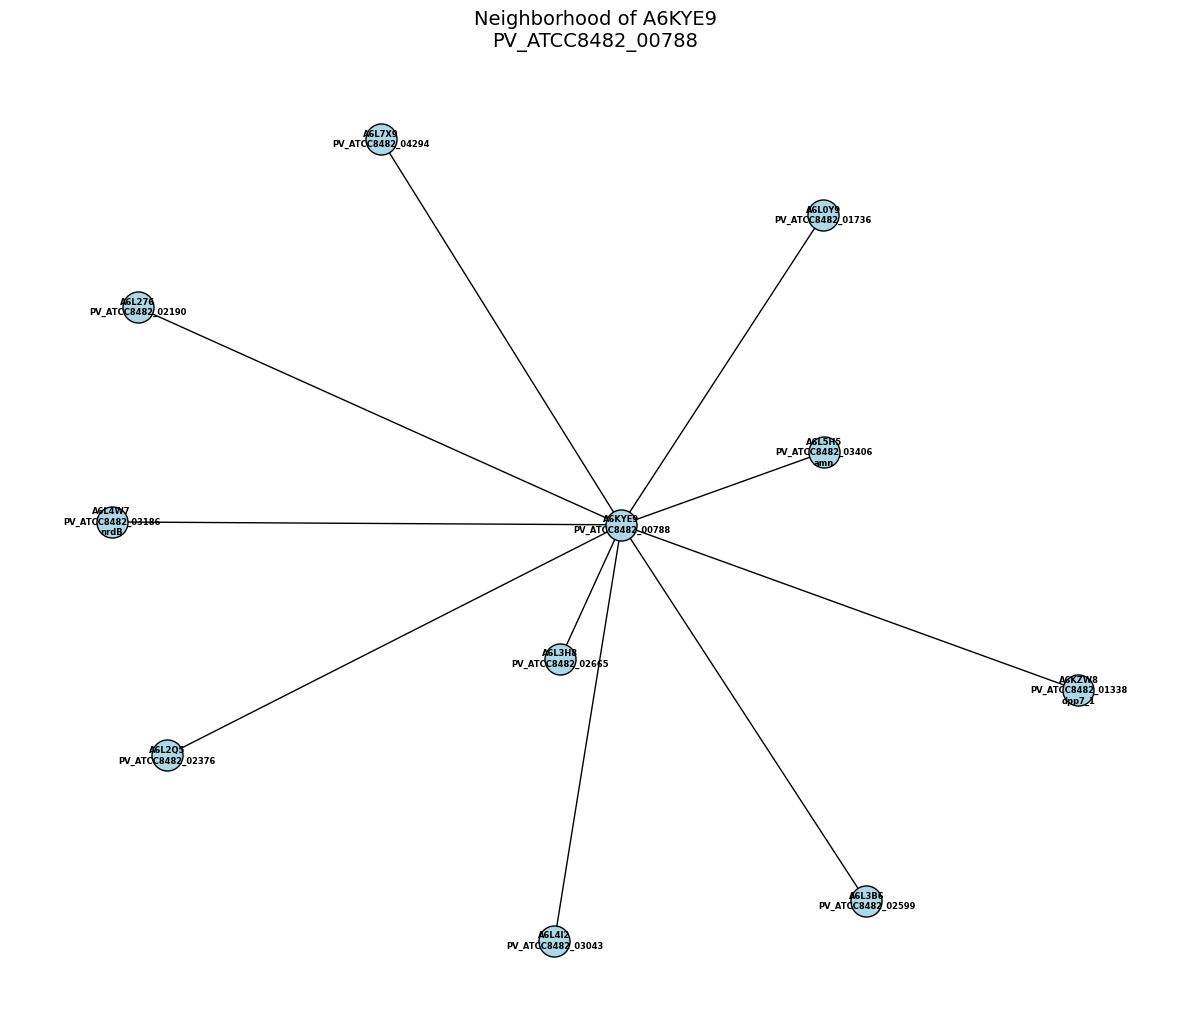


Neighborhood analysis for A6KYE9:
  Total edges: 10
  Central protein edges: 10
  Neighbor-to-neighbor edges: 0
  ⚠️  Star pattern (no neighbor-to-neighbor interactions)


In [6]:
# Clustering coefficient analysis using API
# First, get network properties to identify highly connected proteins
print("Analyzing network properties for melt_score (threshold: 0.98)...")
species_acronym = 'PV'  # Phocaeicola vulgatus
properties = ppi_api.get_network_properties('melt_score', 0.98, species_acronym)

print(f"Network has {properties['num_nodes']} nodes and {properties['num_edges']} edges")
print(f"Average clustering coefficient: {properties['avg_clustering_coefficient']:.4f}")

# For the highest clustering coefficient analysis, we'll use a different approach
# Since the API doesn't directly provide individual protein clustering coefficients,
# we'll build a local network for this specific analysis
print("\nBuilding local network for clustering coefficient analysis...")
melt_net = interaction_network_from_df(
    interactions_df,
    score_col='melt_score',
    score_threshold=0.98
)

if melt_net.number_of_nodes() > 0:
    top_cc_node = get_node_with_highest_clustering_coefficient(melt_net)
    print(f"Protein with highest clustering coefficient: {top_cc_node}")
    
    # Now use the API to plot the neighborhood of this protein
    # Use n=5 to ensure we get neighbor-to-neighbor interactions
    print(f"Plotting neighborhood for {top_cc_node} using API (n=5 for better neighbor interactions)...")
    try:
        plot_neighborhood_from_api(top_cc_node, n=5, species_acronym=species_acronym)
        
        # Also show some statistics about the neighborhood
        print(f"\nNeighborhood analysis for {top_cc_node}:")
        neighborhood_data = ppi_api.get_protein_neighborhood(top_cc_node, n=5, species_acronym=species_acronym)
        edges = neighborhood_data['network_data']['edges']
        
        # Count different types of edges
        central_edges = [e for e in edges if e['source'] == top_cc_node or e['target'] == top_cc_node]
        neighbor_edges = [e for e in edges if e['source'] != top_cc_node and e['target'] != top_cc_node]
        
        print(f"  Total edges: {len(edges)}")
        print(f"  Central protein edges: {len(central_edges)}")
        print(f"  Neighbor-to-neighbor edges: {len(neighbor_edges)}")
        
        if neighbor_edges:
            print(f"  ✅ Complete network with neighbor interactions!")
            for edge in neighbor_edges:
                print(f"    {edge['source']} ↔ {edge['target']} (weight: {edge['weight']:.6f})")
        else:
            print(f"  ⚠️  Star pattern (no neighbor-to-neighbor interactions)")
            
    except Exception as e:
        print(f"API neighborhood plotting failed: {e}")
        print("Falling back to local plotting...")
        plot_neighborhood(melt_net, top_cc_node, 5, gff_df)
else:
    print("No proteins found in the network with the specified threshold.")
    print("Try lowering the threshold or using a different score type.")